In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import utils

In [2]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = utils.load_fashion_mnist_data()
x_train_flat = K.batch_flatten(x_train)
x_val_flat = K.batch_flatten(x_val)
print(f"x_train.shape = {x_train.shape}, x_val.shape = {x_val.shape}")
print(f"x_train_flat.shape = {x_train_flat.shape}, x_val_flat.shape = {x_val_flat.shape}")

x_train.shape = (55000, 28, 28), x_val.shape = (5000, 28, 28)
x_train_flat.shape = (55000, 784), x_val_flat.shape = (5000, 784)


In [3]:
def train_autoencoder(num_neurons, x_train, x_val, loss, optimizer,
                      num_epochs=10, output_activation=None, metrics=None):
    num_inputs = x_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(num_neurons, activation='selu', input_shape=[num_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(num_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    autoencoder.fit(
        x_train, x_train,
        epochs=num_epochs,
        validation_data=(x_val, x_val)
    )
    return encoder, decoder, encoder(x_train), encoder(x_val)

In [4]:
utils.reset_session()

In [5]:
enc_1, dec_1, x_train_enc_1, x_val_enc_1 = train_autoencoder(
    num_neurons=100, 
    x_train=x_train_flat, 
    x_val=x_val_flat, 
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=1.5), 
    output_activation='sigmoid',
    metrics=[utils.rounded_accuracy]
)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [6]:
print(f"x_train_enc_1.shape = {x_train_enc_1.shape}, x_val_enc_1.shape = {x_val_enc_1.shape}")

x_train_enc_1.shape = (55000, 100), x_val_enc_1.shape = (5000, 100)


In [7]:
enc_2, dec_2, _, _ = train_autoencoder(
    num_neurons=30, 
    x_train=x_train_enc_1, 
    x_val=x_val_enc_1, 
    loss='mse',
    optimizer=keras.optimizers.SGD(lr=0.05), 
    output_activation='selu'
)

Epoch 1/10
1719/1719 [==============================] - 1s 527us/step - loss: 0.5619 - val_loss: 0.3466
Epoch 2/10
1719/1719 [==============================] - 1s 494us/step - loss: 0.2611 - val_loss: 0.2367
Epoch 3/10
1719/1719 [==============================] - 1s 491us/step - loss: 0.2252 - val_loss: 0.2173
Epoch 4/10
1719/1719 [==============================] - 1s 512us/step - loss: 0.2109 - val_loss: 0.2058
Epoch 5/10
1719/1719 [==============================] - 1s 494us/step - loss: 0.2035 - val_loss: 0.1973
Epoch 6/10
1719/1719 [==============================] - 1s 525us/step - loss: 0.1987 - val_loss: 0.1978
Epoch 7/10
1719/1719 [==============================] - 1s 490us/step - loss: 0.1971 - val_loss: 0.1998
Epoch 8/10
1719/1719 [==============================] - 1s 487us/step - loss: 0.1955 - val_loss: 0.2003
Epoch 9/10
1719/1719 [==============================] - 1s 490us/step - loss: 0.1949 - val_loss: 0.1933
Epoch 10/10
1719/1719 [==============================] - 1s 486u

In [8]:
stacked_autoencoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc_1,
    enc_2,
    dec_2, 
    dec_1,
    keras.layers.Reshape([28, 28])
])

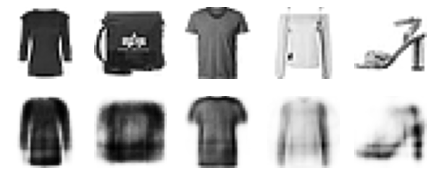

In [9]:
utils.reconstruct(stacked_autoencoder, x_val[:5])

In [10]:
optimizer = keras.optimizers.SGD(lr=0.1)
stacked_autoencoder.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[utils.rounded_accuracy])
history = stacked_autoencoder.fit(
    x_train, x_train,
    epochs=10,
    validation_data=(x_val, x_val)
)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

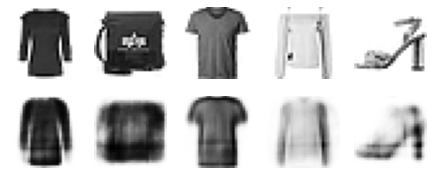

In [11]:
utils.reconstruct(stacked_autoencoder, x_val[:5])